Install `xlrd` for reading the `xls` file

In [1]:
# %conda install xlrd==2.0.1

Set the path to the `xls` file

In [2]:
training_file = "../TrainDataset2024.xls"
# training_file = "/kaggle/input/dataset/TrainDataset2024.xls"

Import libraries

In [3]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('../'))  # Adjust the path as needed

from my_util import df_to_corr_matrix, remove_outliers

from enum import Enum

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, make_scorer, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from joblib import Parallel, delayed

from pickle import dump , load

import warnings

2024-12-03 23:09:27.252918: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 23:09:27.264333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733267367.278482  132191 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733267367.282416  132191 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 23:09:27.294768: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Read the data and load the selected features

In [4]:
NUM_OF_SELECTED_FEATURES = "corr_25"

data = pd.read_excel(training_file)
data.replace(999, np.nan, inplace=True)

data.drop(["ID", "RelapseFreeSurvival (outcome)"], axis=1, inplace=True)
data.dropna(subset=["pCR (outcome)"], inplace=True)

with open(f'../FeatureSelection/pkl/{NUM_OF_SELECTED_FEATURES}_selected_features.pkl', mode='rb') as file:
    selected_features = load(file)
    print(f"Loaded '{file.name}' to selected_feature")

X = data[selected_features]
y = data["pCR (outcome)"]
print(X.shape, y.shape)

print(selected_features)

Loaded '../FeatureSelection/pkl/corr_25_selected_features.pkl' to selected_feature
(395, 25) (395,)
['Gene', 'HER2', 'PgR', 'ER', 'original_firstorder_10Percentile', 'original_ngtdm_Busyness', 'LNStatus', 'TumourStage', 'original_gldm_DependenceEntropy', 'original_firstorder_Skewness', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_ngtdm_Strength', 'original_gldm_SmallDependenceEmphasis', 'original_firstorder_InterquartileRange', 'original_shape_MajorAxisLength', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_firstorder_Minimum', 'HistologyType', 'ChemoGrade', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterColumn', 'original_shape_SurfaceVolumeRatio', 'original_shape_LeastAxisLength', 'original_glcm_Autocorrelation', 'original_shape_Sphericity']


### Split the data into train_full and test_reserved (untouch)

In [5]:
# Close ratio random_state
# [14, 47, 49, 52, 62, 76, 83, 89, 92, 116, 118, 122, 136, 138, 144, 146, 150, 156, 157, 159, 170, 172, 174, 185]

while True:  
    X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=14) # similar distribution of 1 and 0
    # X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=None)

    X_train_full.reset_index(drop=True, inplace=True)
    X_test_reserved.reset_index(drop=True, inplace=True)
    y_train_full.reset_index(drop=True, inplace=True)
    y_test_reserved.reset_index(drop=True, inplace=True)

    ratio_train = sum(y_train_full[y_train_full==1]) / len(y_train_full)
    ratio_test = sum(y_test_reserved[y_test_reserved==1]) / len(y_test_reserved)

    if abs(ratio_train - ratio_test) < 0.1:
        break

print("Splited the data into train and test. The test will not be used in the training, but just for test the model. ")
print(f"The training data has {len(X_train_full)} data. The testing data has {len(X_test_reserved)} data. ")
print(f"Positive ratio: \n\tTrain: {ratio_train:.5f}\n\tTest: {ratio_test:.5f}")

Splited the data into train and test. The test will not be used in the training, but just for test the model. 
The training data has 316 data. The testing data has 79 data. 
Positive ratio: 
	Train: 0.21203
	Test: 0.21519


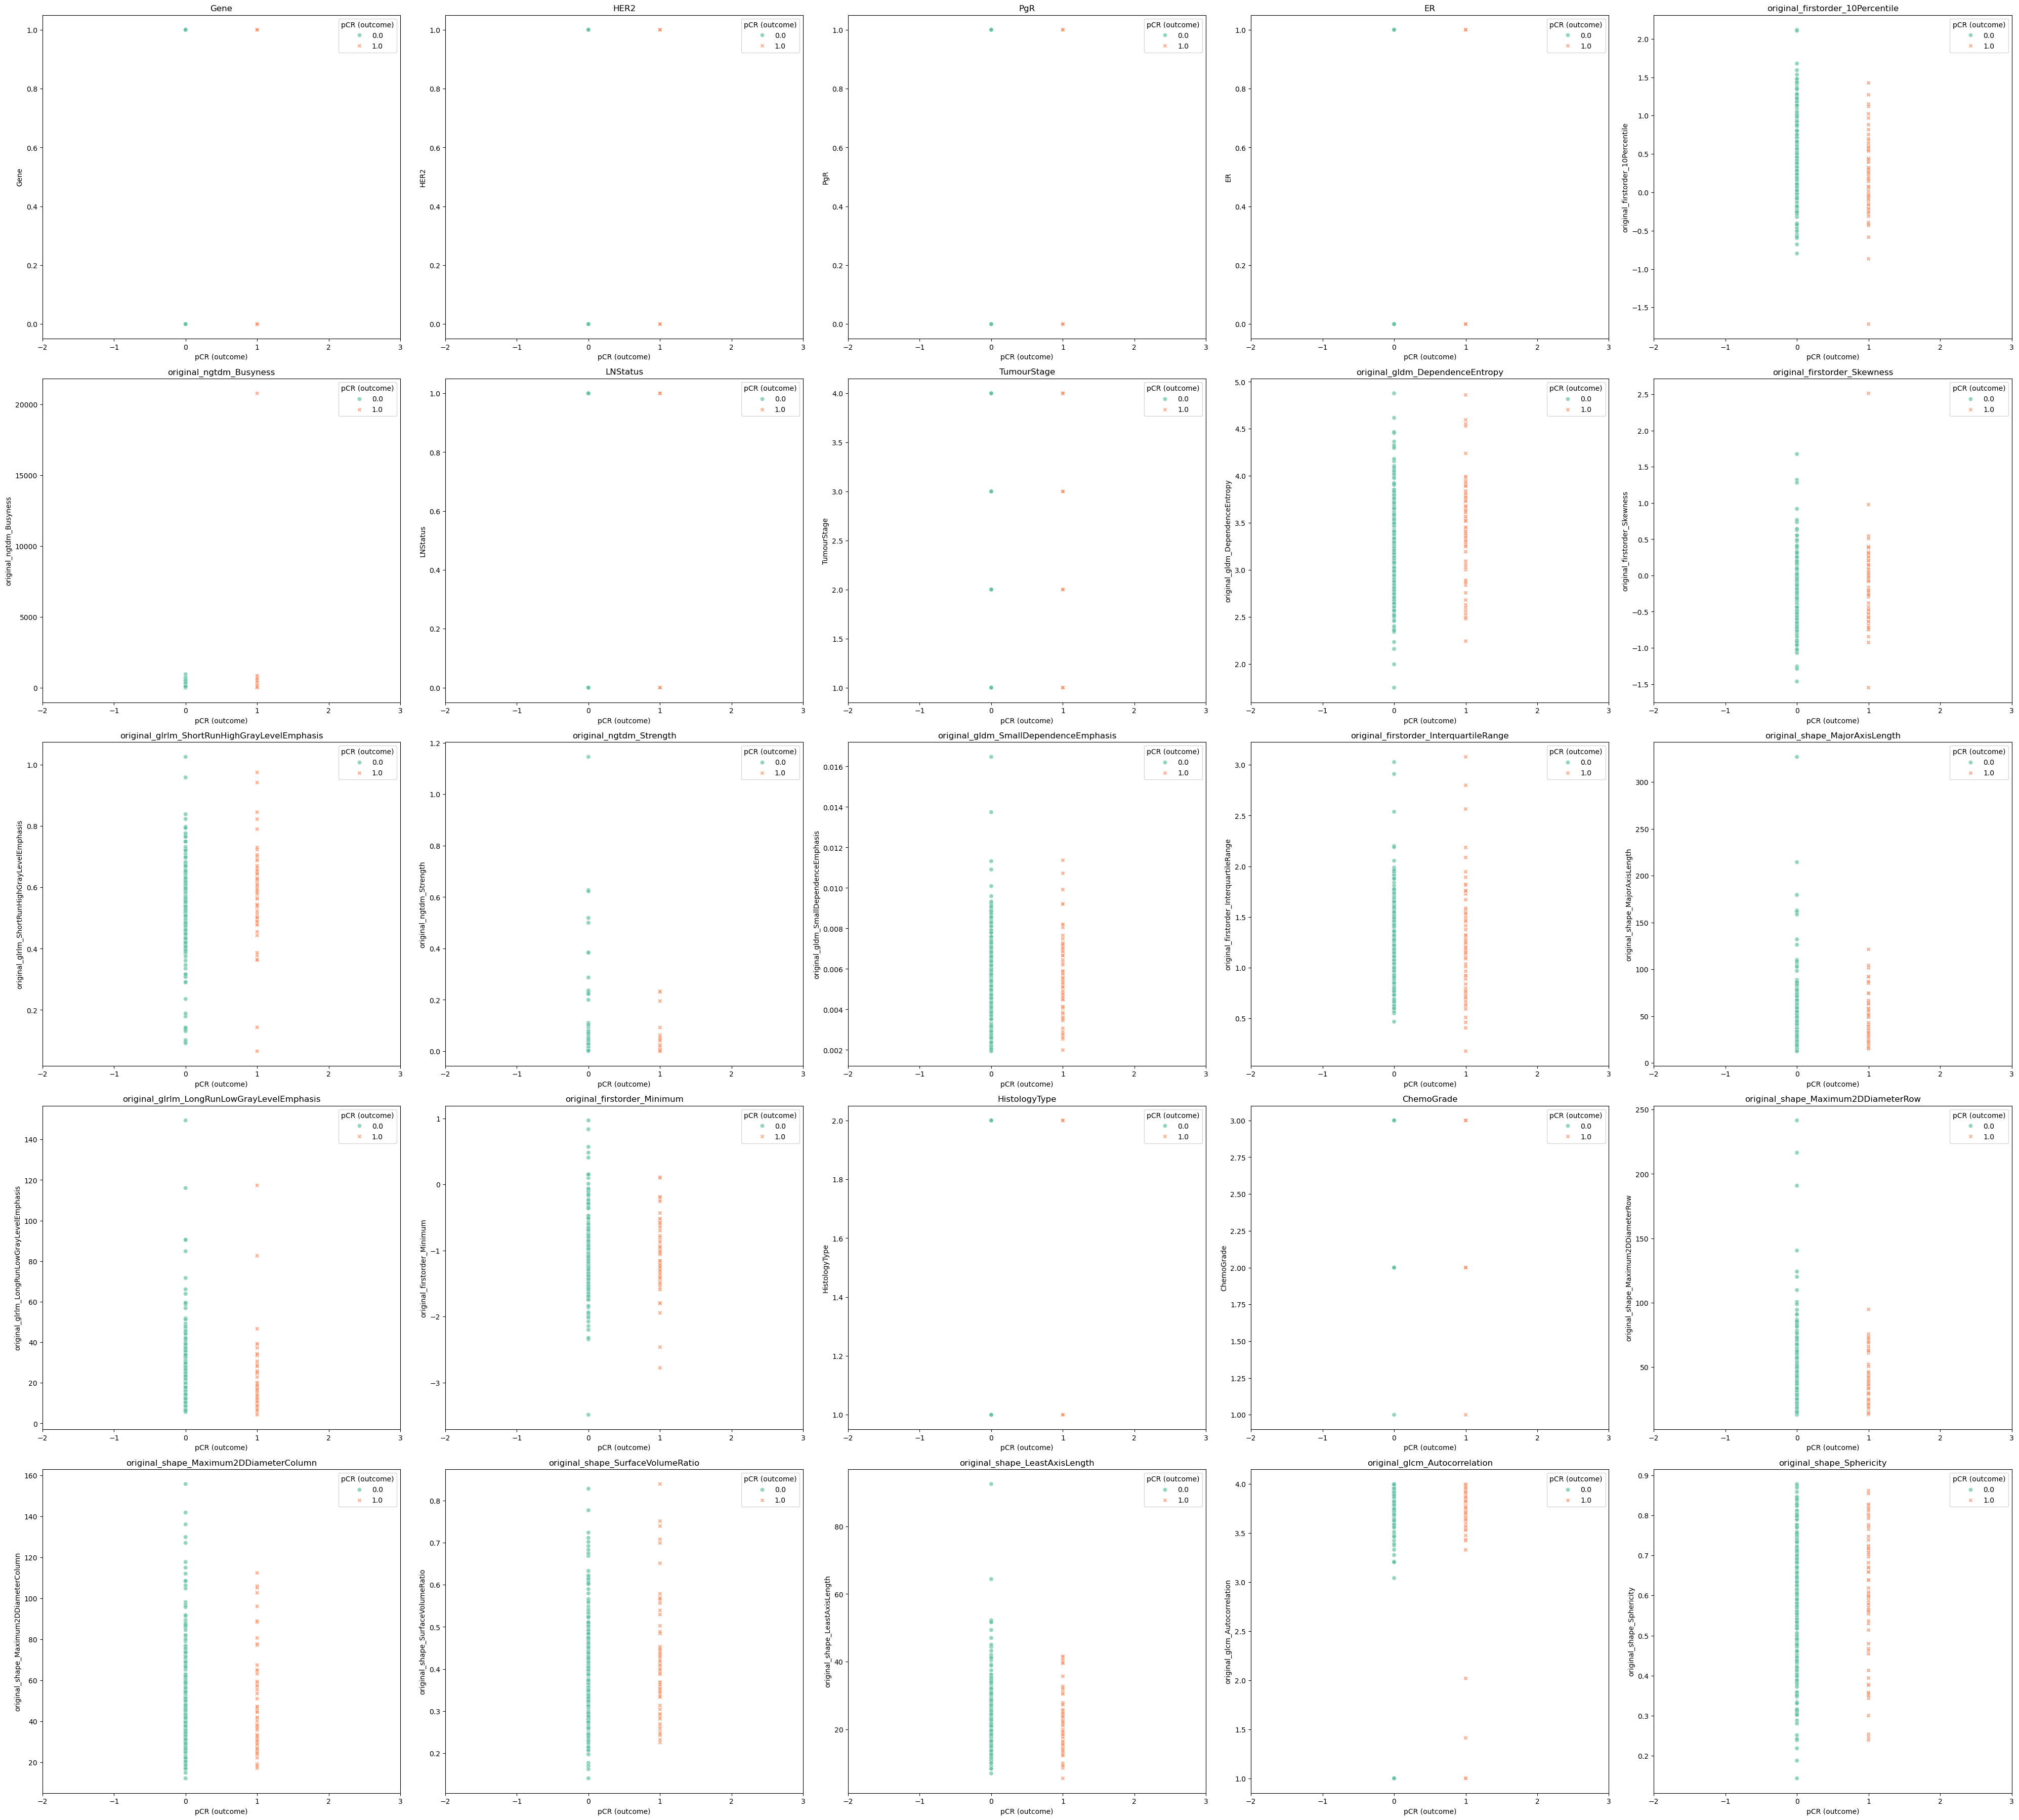

In [6]:
def show_scatter_plots():
    # Set up the matplotlib figure
    plt.figure(figsize=(40, 50))

    # Loop through each feature to create a scatter plot
    for i, feature in enumerate(X_train_full.columns):
        plt.subplot(7, 5, i + 1)  # Adjust the number of rows and columns based on the number of features
        sns.scatterplot(x=y_train_full, y=X_train_full[feature], hue=y_train_full, style=y_train_full, palette='Set2', alpha=0.7)
        plt.title(feature)
        plt.xlabel('pCR (outcome)')
        plt.ylabel(feature)
        plt.xlim(-2, 3)

    plt.tight_layout()
    plt.show()
show_scatter_plots()

### Remove outliers

In [7]:
X_train_full, y_train_full = remove_outliers(X_train_full, y_train_full, selected_features)

Replaced 3 records in original_firstorder_10Percentile[0] to 1.678166
Replaced 2 records in original_firstorder_10Percentile[1] to -0.617352
Replaced 2 records in original_ngtdm_Busyness[1] to 838.677442
Replaced 1 records in original_gldm_DependenceEntropy[1] to 2.478963
Replaced 2 records in original_firstorder_Skewness[1] to 0.545105
Replaced 5 records in original_firstorder_Skewness[0] to 0.767485
Replaced 1 records in original_firstorder_Skewness[1] to -0.995207
Replaced 2 records in original_glrlm_ShortRunHighGrayLevelEmphasis[1] to 0.363247
Replaced 2 records in original_glrlm_ShortRunHighGrayLevelEmphasis[0] to 0.838612
Replaced 2 records in original_gldm_SmallDependenceEmphasis[0] to 0.011321
Replaced 4 records in original_shape_MajorAxisLength[0] to 162.863366
Replaced 3 records in original_glrlm_LongRunLowGrayLevelEmphasis[1] to 39.241005
Replaced 2 records in original_glrlm_LongRunLowGrayLevelEmphasis[0] to 90.572934
Replaced 2 records in original_firstorder_Minimum[0] to -

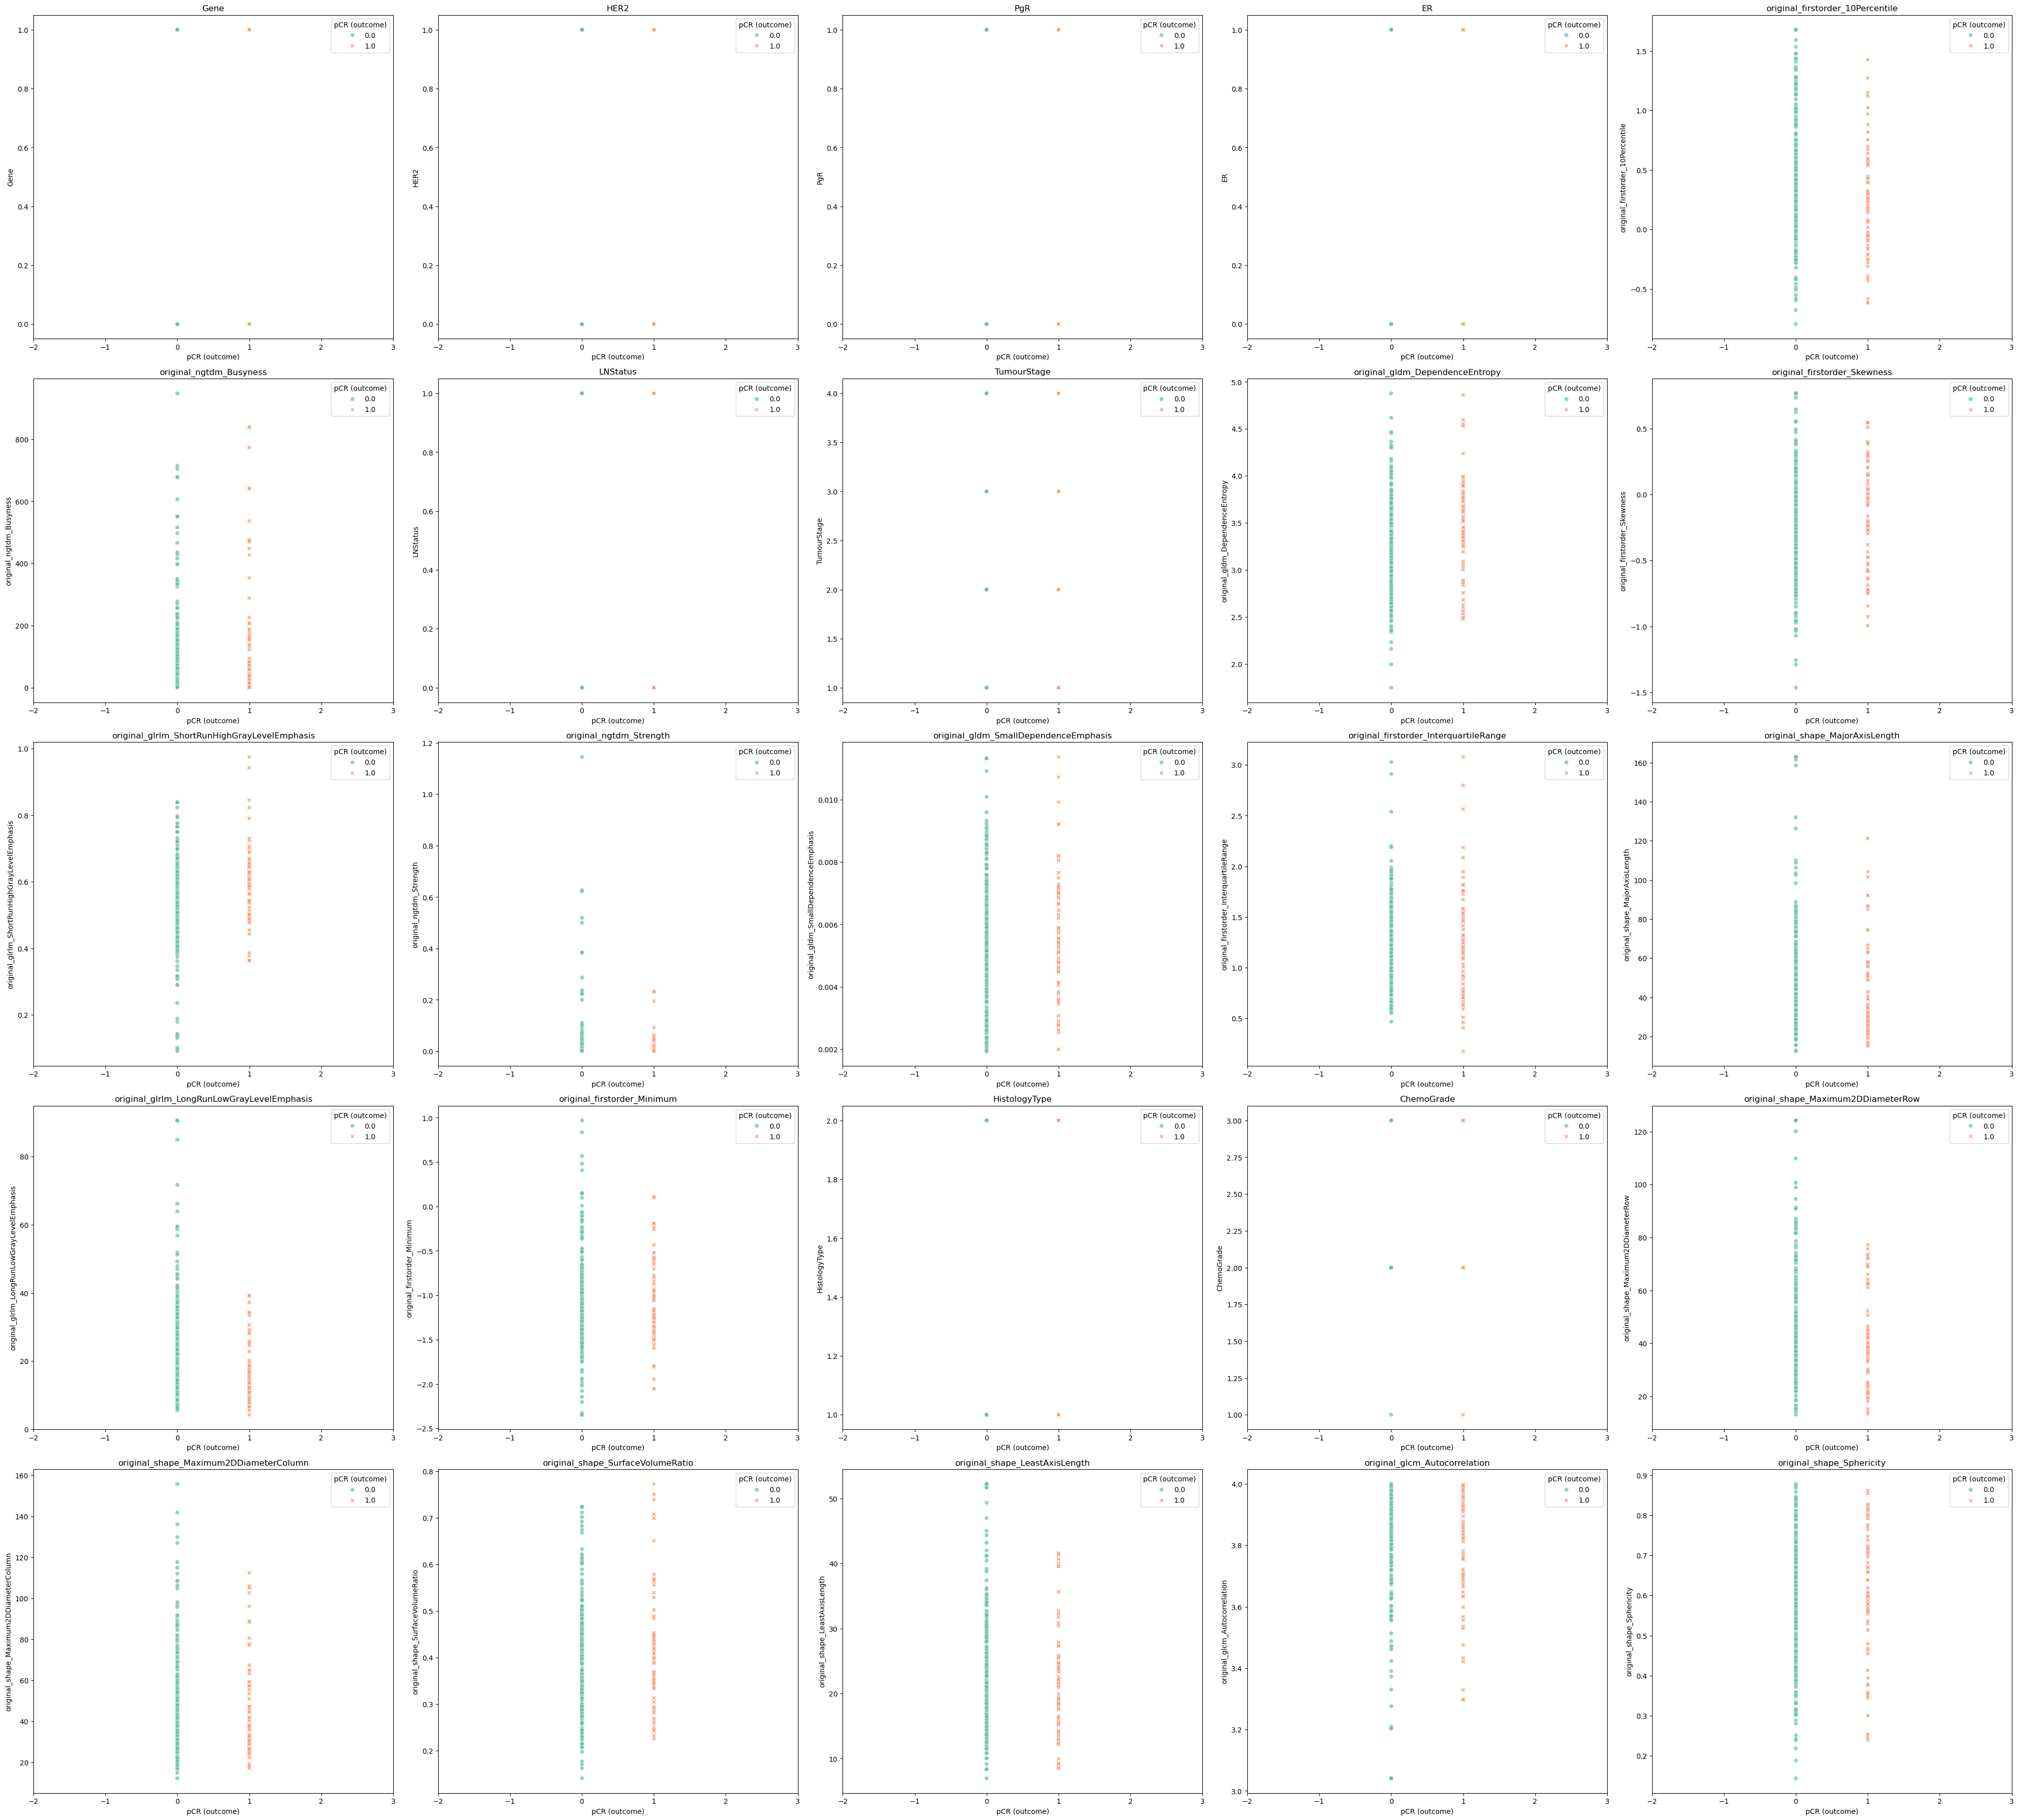

In [8]:
show_scatter_plots()

### KNNImputer

In [9]:
n_neighbors = 11

imputer = KNNImputer(n_neighbors=n_neighbors)
X_train_full = pd.DataFrame(imputer.fit_transform(X_train_full), columns=X_train_full.columns)
print("Imputed training data with KNNImputer. Read the data into X_train_full and y_train_full.")
print(X_train_full.shape, y_train_full.shape)

with open("pkl/imputer.pkl", 'wb') as file:
    dump(imputer, file)
    print(f"Saved imputer to '{file.name}'")

Imputed training data with KNNImputer. Read the data into X_train_full and y_train_full.
(316, 25) (316,)
Saved imputer to 'pkl/imputer.pkl'


### Normalisation

##### Standardisation

In [10]:
scaler = StandardScaler()
Xs_standardisation = scaler.fit_transform(X_train_full)
Xs_standardisation = pd.DataFrame(Xs_standardisation, columns=X_train_full.columns)

with open("pkl/StandardScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/StandardScaler.pkl'")

Saved scaler to 'pkl/StandardScaler.pkl'


##### Robust Scaler

In [11]:
scaler = RobustScaler()
Xs_robustScaler = scaler.fit_transform(X_train_full)
Xs_robustScaler = pd.DataFrame(Xs_robustScaler, columns=X_train_full.columns)

with open("pkl/RobustScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/RobustScaler.pkl'")

Saved scaler to 'pkl/RobustScaler.pkl'


In [12]:
SCALER = "standard"

In [13]:
# SCALER = "robust"

In [14]:
if SCALER == "standard":
    Xs = Xs_standardisation
else:
    Xs = Xs_robustScaler

(25, 25)


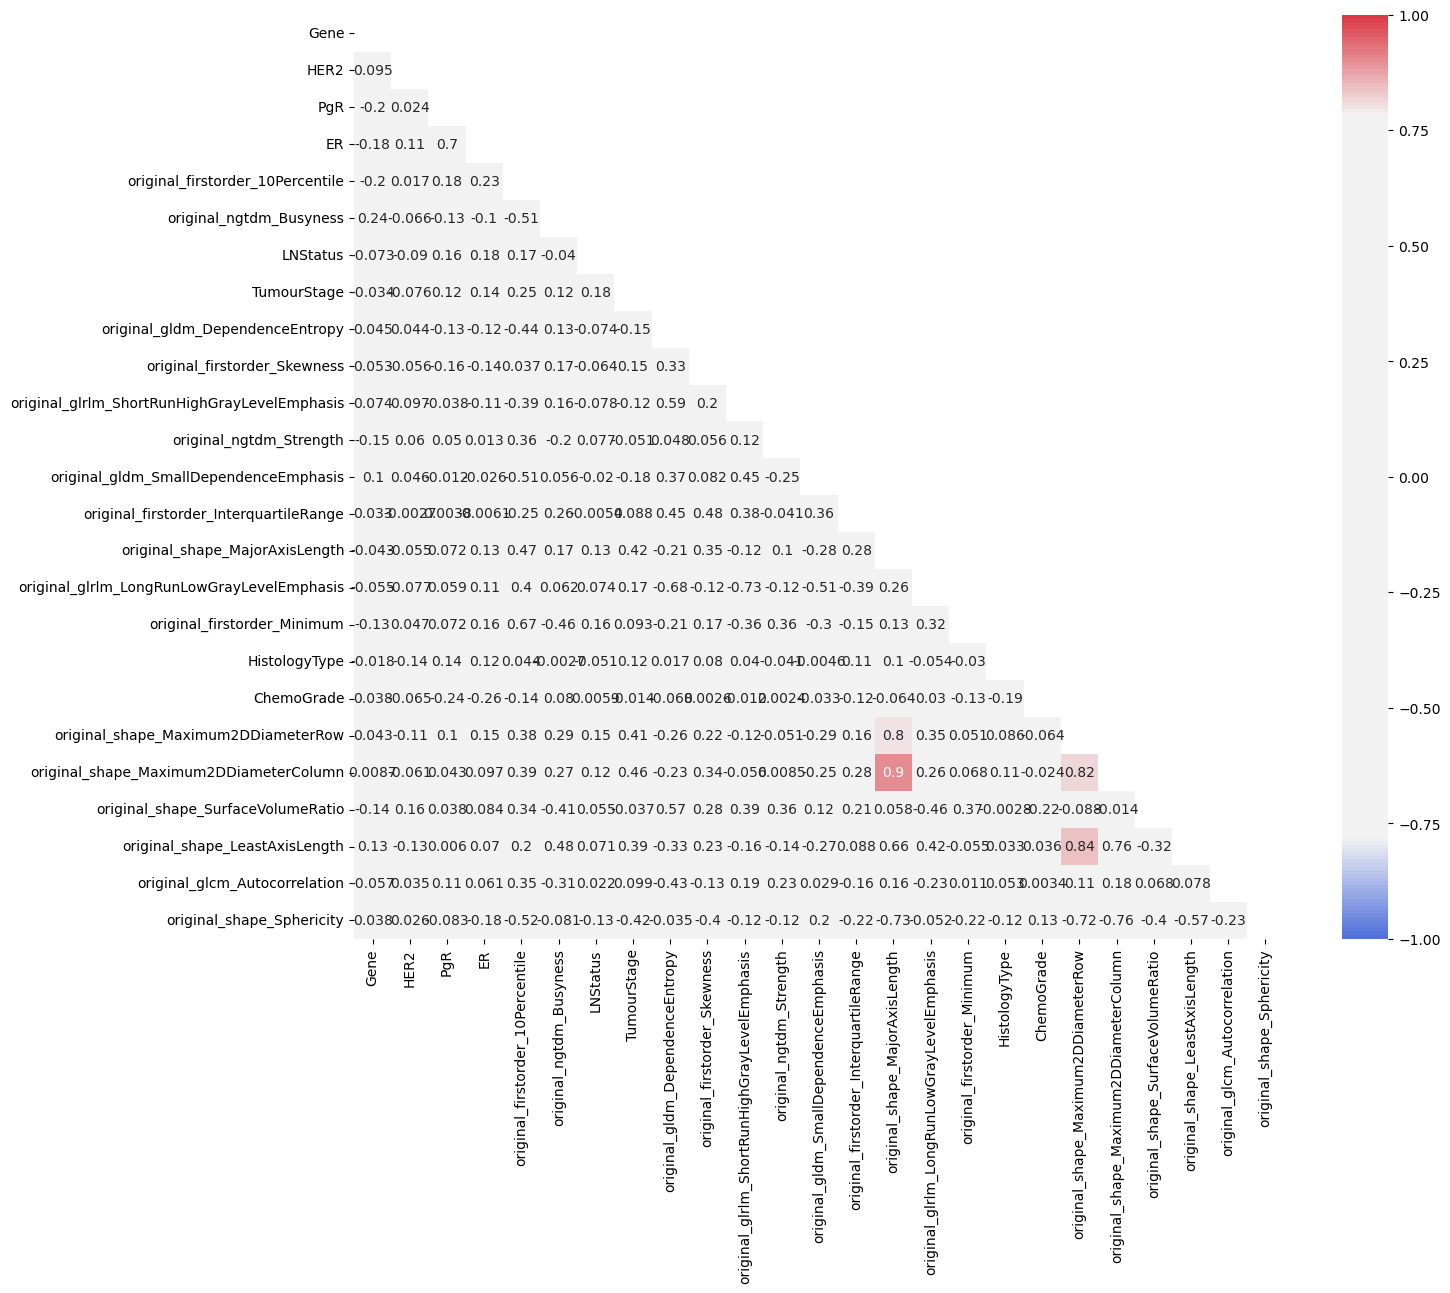

In [15]:
df_to_corr_matrix(Xs, size_factor=1.5)

### IMB Pipeline

In [16]:
pipeline = Pipeline([
#   ('pca', PCA()),
  ('sampling', SMOTE()),
  ('forest', RandomForestClassifier()),
])

param_grid = {
    # 'pca__n_components': [9, 11, 13, 14, 15],
    'forest__criterion': ['gini', 'entropy', 'log_loss'],
    'forest__max_depth': [None, 1, 2],
    'forest__max_leaf_nodes': [None, 1, 2, 4, 8],
    'forest__min_samples_leaf': [1, 5, 10, 20, 30, 40],
    'forest__min_samples_split': [2, 3, 5],
    'forest__n_estimators': [50, 100, 200, 300, 400],
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
      "f1": "f1", 
      "recall": "recall", 
      'specificity': make_scorer(recall_score,pos_label=0),
      'precision': 'precision',
      'balanced_accuracy_score': make_scorer(balanced_accuracy_score)
      },
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    refit="balanced_accuracy_score",
)

# Fit the model
grid_search.fit(X_train_full, y_train_full)

# Get the best parameters and best score
result = pd.DataFrame(grid_search.cv_results_)
best_params = grid_search.best_params_
best_index = grid_search.best_index_
best_f1 = result["mean_test_f1"][best_index]
best_precision = result["mean_test_precision"][best_index]
best_recall = result["mean_test_recall"][best_index]
best_specificity = result["mean_test_specificity"][best_index]
best_balanced_accuracy_score = result["mean_test_balanced_accuracy_score"][best_index]

print(f"Best Parameters at Index {best_index} :", best_params)
print(f"Balanced accuracy score: {best_balanced_accuracy_score}")
print(f"F1 Score: {best_f1}")
print(f"Precision Score: {best_precision}")
print(f"Recall Score: {best_recall}")
print(f"Specificity Score: {best_specificity}")

pd.DataFrame(grid_search.cv_results_).to_csv("output.csv")

Fitting 5 folds for each of 4050 candidates, totalling 20250 fits


/home/ubuntu/miniconda3/envs/MLEAsm/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
4050 fits failed out of a total of 20250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4050 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/MLEAsm/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/miniconda3/envs/MLEAsm/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ubuntu/miniconda3/envs/MLEAsm/lib/python3.10/site-packages/imblearn/pipeline.py", 

Best Parameters at Index 3526 : {'forest__criterion': 'log_loss', 'forest__max_depth': 1, 'forest__max_leaf_nodes': 8, 'forest__min_samples_leaf': 5, 'forest__min_samples_split': 2, 'forest__n_estimators': 100}
Balanced accuracy score: 0.7860282574568288
F1 Score: 0.600310633499488
Precision Score: 0.47972877846790885
Recall Score: 0.8087912087912089
Specificity Score: 0.763265306122449


In [17]:
results = pd.DataFrame(grid_search.cv_results_)
print(list(results.keys())[4:10])

['param_forest__criterion', 'param_forest__max_depth', 'param_forest__max_leaf_nodes', 'param_forest__min_samples_leaf', 'param_forest__min_samples_split', 'param_forest__n_estimators']


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)

filter = results['mean_train_recall'] == 1
filter = pd.Series([True] * len(results)) # include all data

fig = go.Figure()
# Add mean train score trace
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_train_f1"][filter]))),
    y=results["mean_train_f1"][filter],
    mode='lines+markers',
    name='Mean Train F1',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_train_recall"][filter]))),
    y=results["mean_train_recall"][filter],
    mode='lines+markers',
    name='Mean Train Recall',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
# Add mean test score trace
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_test_f1"][filter]))),
    y=results["mean_test_f1"][filter],
    mode='lines+markers',
    name='Mean Test F1',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_test_recall"][filter]))),
    y=results["mean_test_recall"][filter],
    mode='lines+markers',
    name='Mean Test Recall',
    text=list(results['params'][filter]),  # Display parameter values on hover
    hoverinfo='text+y+x',  # Show parameter values and y value
))

# Update layout
fig.update_layout(
    title='Grid Search Mean Train and Test Scores',
    xaxis_title='Parameter Combinations (Index)',
    yaxis_title='Score',
    legend_title='Scores',
    hovermode='closest'
)
fig.show()

In [20]:
model = grid_search.best_estimator_

with open("pkl/StandardScaler.pkl", "rb") as file:
  scaler = load(file)

with open("pkl/imputer.pkl", "rb") as file:
  imputer = load(file)

model = grid_search.best_estimator_

y_pred = model.predict(Xs)

report = classification_report(y_train_full, y_pred)
cm = confusion_matrix(y_train_full, y_pred)

print("Training set:")
print(f"Best Parameters at Index {best_index} :", best_params)
print(Xs.shape)
print(report)
print(cm)
print()
print(f"Balanced accuracy score: {balanced_accuracy_score(y_train_full, y_pred)}")
print(f"F1 Score: {f1_score(y_train_full, y_pred)}")
print(f"Precision: {precision_score(y_train_full, y_pred)}")
print(f"Recall: {recall_score(y_train_full, y_pred)}")
print(f"Specificity: {recall_score(y_train_full, y_pred, pos_label=0)}")


X_test = imputer.transform(X_test_reserved)
X_test = pd.DataFrame(X_test, columns=X_test_reserved.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_test_reserved.columns)

y_pred = model.predict(X_test)
report = classification_report(y_test_reserved, y_pred)
cm = confusion_matrix(y_test_reserved, y_pred)

print()
print()
print("Testing set:")
print(X_test_reserved.shape)
print(report)
print(cm)
print()
print(f"Balanced accuracy score: {balanced_accuracy_score(y_test_reserved, y_pred)}")
print(f"F1 Score: {f1_score(y_test_reserved, y_pred)}")
print(f"Precision: {precision_score(y_test_reserved, y_pred)}")
print(f"Recall: {recall_score(y_test_reserved, y_pred)}")
print(f"Specificity: {recall_score(y_test_reserved, y_pred, pos_label=0)}")


Training set:
Best Parameters at Index 3526 : {'forest__criterion': 'log_loss', 'forest__max_depth': 1, 'forest__max_leaf_nodes': 8, 'forest__min_samples_leaf': 5, 'forest__min_samples_split': 2, 'forest__n_estimators': 100}
(316, 25)
              precision    recall  f1-score   support

         0.0       0.88      0.71      0.78       249
         1.0       0.37      0.64      0.47        67

    accuracy                           0.69       316
   macro avg       0.63      0.67      0.63       316
weighted avg       0.77      0.69      0.72       316

[[176  73]
 [ 24  43]]

Balanced accuracy score: 0.6743091770065336
F1 Score: 0.46994535519125685
Precision: 0.3706896551724138
Recall: 0.6417910447761194
Specificity: 0.7068273092369478


Testing set:
(79, 25)
              precision    recall  f1-score   support

         0.0       0.86      0.69      0.77        62
         1.0       0.34      0.59      0.43        17

    accuracy                           0.67        79
   macro 

In [ ]:
X_test = imputer.transform(X)
X_test = pd.DataFrame(X_test, columns=X_test_reserved.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_test_reserved.columns)